In [ ]:
#Libraries
import pathlib
import random
import string
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import callbacks
from keras.saving import register_keras_serializable

In [ ]:
import pandas as pd

# load csv
df = pd.read_csv("/content/output_data1.csv")

# write to required files (Telugu → English)
df["telugu"].to_csv("train.te", index=False, header=False)
df["english"].to_csv("train.en", index=False, header=False)


In [ ]:
eng_file = '/content/train.en'
telugu_file = '/content/train.te'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
with open(eng_file, 'r') as file:
    english_sentences = file.readlines()
with open(telugu_file, 'r') as file:
    telugu_sentences = file.readlines()

english_sentences = [sentence.rstrip('\n').lower() for sentence in english_sentences]
telugu_sentences = [sentence.rstrip('\n') for sentence in telugu_sentences]


In [ ]:
telugu_vocabulary = [
    ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/',
    '0','1','2','3','4','5','6','7','8','9', ':', '<', '=', '>', '?',
    "అ","ఆ","ఇ","ఈ","ఉ","ఊ","ఋ","ఎ","ఏ","ఐ","ఒ","ఓ","ఔ",
    "క","ఖ","గ","ఘ","ఙ",
    "చ","ఛ","జ","ఝ","ఞ",
    "ట","ఠ","డ","ఢ","ణ",
    "త","థ","ద","ధ","న",
    "ప","ఫ","బ","భ","మ",
    "య","ర","ల","వ",
    "శ","ష","స","హ","ళ","క్ష","ఱ",
    "ా","ి","ీ","ు","ూ","ృ","ె","ే","ై","ొ","ో","ౌ",
    "ం","ః","్",
    "౦","౧","౨","౩","౪","౫","౬","౭","౮","౯"
]

english_vocabulary = [' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/',
                        '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                        ':', '<', '=', '>', '?', '@',
                        '[', '\\', ']', '^', '_', '`',
                        'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l',
                        'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x',
                        'y', 'z',
                        '{', '|', '}', '~']


In [ ]:
MAX_LEN = 30

telugu_sentences  = open("train.te", encoding="utf-8").read().splitlines()
english_sentences = open("train.en", encoding="utf-8").read().splitlines()

valid_sentence_indicies = [
    i for i in range(len(english_sentences))
    if len(english_sentences[i].split()) <= MAX_LEN
    and len(telugu_sentences[i].split()) <= MAX_LEN
]


In [ ]:
len(df)

175621

In [ ]:
TOTAL_SENTENCES = 175621
x = [telugu_sentences[i] for i in valid_sentence_indicies]
y = [english_sentences[i] for i in valid_sentence_indicies]


In [ ]:
import pandas as pd
dataset = pd.DataFrame({"Telugu": x, "English": y})
dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175609 entries, 0 to 175608
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Telugu   175609 non-null  object
 1   English  175609 non-null  object
dtypes: object(2)
memory usage: 2.7+ MB


In [ ]:
dataset.sample(5)

,Telugu,English
117070,వారు నా ఖర్చుతో చాలా ఆనందించారు.,They had great fun at my expense.
150135,"""మీరు ఎప్పుడైనా జపాన్‌లో ఉంటే, వచ్చి నన్ను చూడ...","""If you are ever in Japan, come and see me."""
173742,"""నేను స్ట్రీట్‌కార్ కోసం ఎదురు చూస్తున్నప్పుడు...","""While I was waiting for the streetcar, I witn..."
167183,నేను నిన్న రాత్రి ఈ సినిమా చూశాను మరియు నాకు బ...,I watched this movie last night and I really l...
161098,నా చిన్న జీతం గురించి ఆమె ఎప్పుడూ ఫిర్యాదు చేస...,She is always complaining about my small salary.


In [ ]:
import os

save_dir = "/content/drive/MyDrive/Project_2_new2"
os.makedirs(save_dir, exist_ok=True)

dataset.to_csv(os.path.join(save_dir, "data.csv"), index=False)

In [ ]:
dataset = pd.read_csv('/content/output_data1.csv')
dataset.head()


,english,telugu
0,Hi.,హాయ్.
1,Run!,పరుగు!
2,Run!,పరుగు!
3,Who?,WHO?
4,Wow!,వావ్!


In [ ]:
text_pairs = []

for i in range(dataset.shape[0]):
    telugu = str(dataset["telugu"][i])
    english = str(dataset["english"][i])
    text_pairs.append(
        (telugu, "[start] " + english + " [end]")
    )


In [ ]:
train_sample_size = len(text_pairs) - int(0.1*len(text_pairs))
train_pairs = text_pairs[:train_sample_size]
test_pairs = text_pairs[train_sample_size:]

In [ ]:
print("Total pairs :", len(text_pairs))
print("Train pairs :", len(train_pairs))
print("Test pairs :", len(test_pairs))

Total pairs : 175621
Train pairs : 158059
Test pairs : 17562


In [ ]:
strip_chars = string.punctuation + "|"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")
strip_chars = strip_chars.replace('""', "")

vocab_size = 35000
sequence_length = 30
batch_size = 64

In [ ]:
def custom_standardization(input_string):
    return tf.strings.regex_replace(input_string, "[%s]" % re.escape(strip_chars), "")


In [ ]:
eng_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)

te_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)


In [ ]:
train_te_texts  = [pair[0] for pair in train_pairs]   # Telugu → encoder
train_eng_texts = [pair[1] for pair in train_pairs]   # English → decoder

te_vectorization.adapt(train_te_texts)
eng_vectorization.adapt(train_eng_texts)


In [ ]:
import json

# Get the vocabulary
eng_vocab = eng_vectorization.get_vocabulary()
te_vocab  = te_vectorization.get_vocabulary()

# Save the vocabulary
with open('/content/eng_vocab.json', 'w') as f:
    json.dump(eng_vocab, f)
with open('/content/te_vocab.json', 'w') as f:
    json.dump(te_vocab, f)


In [ ]:
import json

vocab_size = 35000
sequence_length = 30
batch_size = 64

# Load the vocabulary
with open('/content/eng_vocab.json', 'r') as f:
    eng_vocab = json.load(f)
with open('/content/te_vocab.json', 'r') as f:
    te_vocab = json.load(f)

# Create a TextVectorization layer with the loaded vocabulary
eng_vectorization = TextVectorization(
    vocabulary=eng_vocab,
    output_mode="int",
    output_sequence_length=sequence_length
)

te_vectorization = TextVectorization(
    vocabulary=te_vocab,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization
)


In [ ]:
def format_dataset(telugu, english):
    telugu = te_vectorization(telugu)
    english = eng_vectorization(english)
    return (
        {
            "encoder_inputs": telugu,
            "decoder_inputs": english[:, :-1],
        },
        english[:, 1:],
    )


In [ ]:
def make_dataset(pairs):
    telugu_texts, english_texts = zip(*pairs)
    telugu_texts = list(telugu_texts)
    english_texts = list(english_texts)

    dataset = tf.data.Dataset.from_tensor_slices((telugu_texts, english_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()


In [ ]:
train_ds = make_dataset(train_pairs)
test_ds = make_dataset(test_pairs)

In [ ]:
for inputs, targets in train_ds.take(2):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (64, 31)
inputs["decoder_inputs"].shape: (64, 29)
targets.shape: (64, 29)
inputs["encoder_inputs"].shape: (64, 31)
inputs["decoder_inputs"].shape: (64, 29)
targets.shape: (64, 29)


In [ ]:
@register_keras_serializable()
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

In [ ]:
@register_keras_serializable()
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
         return keras.ops.not_equal(inputs, 0)

In [ ]:
@register_keras_serializable()
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads

        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )

        self.dense_proj = keras.Sequential(
            [
                layers.Dense(latent_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        # Causal self-attention
        causal_mask = self.get_causal_attention_mask(inputs)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask,
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        # Cross-attention (no mask → avoids shape mismatch)
        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        batch_size = tf.shape(inputs)[0]
        seq_len = tf.shape(inputs)[1]

        i = tf.range(seq_len)[:, tf.newaxis]
        j = tf.range(seq_len)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, seq_len, seq_len))
        return tf.tile(mask, [batch_size, 1, 1])


In [ ]:
embed_dim = 256
latent_dim = 512
num_heads = 4

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:1474: UserWarning: Layer 'transformer_encoder_1' looks like it has unbuilt state, but Keras is not able to trace the layer `call()` in order to build it automatically. Possible causes:
1. The `call()` method of your layer may be crashing. Try to `__call__()` the layer eagerly on some test input first to see if it works. E.g. `x = np.random.random((3, 4)); y = layer(x)`
2. If the `call()` method is correct, then you may need to implement the `def build(self, input_shape)` method on your layer. It should create all variables used by the layer (e.g. by calling `layer.build()` on all its children layers).
Exception encountered: ''cannot access local variable 'padding_mask' where it is not associated with a value''
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'transformer_encoder_1', however the layer does not have a `build()` method impleme

In [ ]:
decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

In [ ]:
decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'functional_7' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [ ]:
transformer.summary()

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, None, 256) │  8,967,680 │ encoder_inputs[0… │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, None)      │          0 │ encoder_inputs[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, None, 256) │  1,315,840 │ positional_embed… │
│ (TransformerEncode… │                   │            │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_7        │ (None, None,      │ 20,330,936 │ decoder_inputs[0… │
│ (Functional)        │ 35000)            │            │ transformer_enco… │
│                     │                   │            │ not_equal_2[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 30,614,456 (116.78 MB)

 Trainable params: 30,614,456 (116.78 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
@register_keras_serializable()
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

  def get_config(self):
    return {"d_model": self.d_model.numpy(), "warmup_steps": self.warmup_steps}

In [ ]:
learning_rate = CustomSchedule(latent_dim)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=learning_rate,
    beta_1=0.9,
    beta_2=0.98,
    epsilon=1e-9
)


Text(0.5, 0, 'Train Step')

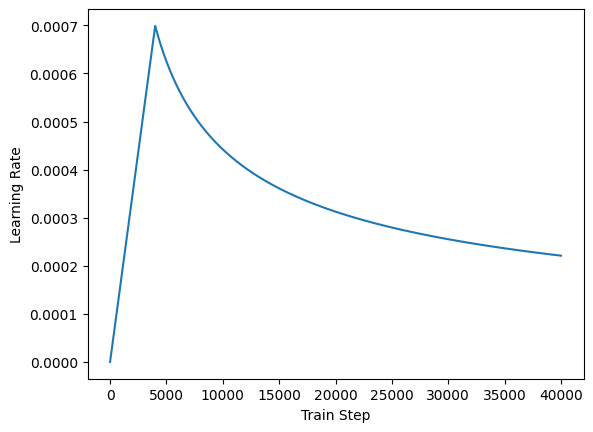

In [ ]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

drive_root = "/content/drive/MyDrive/telugu_transformer"

# Create directories if not exist
os.makedirs(drive_root, exist_ok=True)

checkpoint_filepath = os.path.join(drive_root, "checkpoint_telugu_transformer.keras")
csv_log_filepath = os.path.join(drive_root, "training_log_telugu_transformer.csv")
backup_dir = os.path.join(drive_root, "backup_telugu_transformer")
os.makedirs(backup_dir, exist_ok=True)


In [ ]:
from tensorflow.keras import callbacks

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

csv_logger = callbacks.CSVLogger(csv_log_filepath, append=True)

backup_callback = callbacks.BackupAndRestore(
    backup_dir=backup_dir,
    delete_checkpoint=False
)

all_callbacks = [early_stopping, model_checkpoint_callback, csv_logger, backup_callback]


In [ ]:
epochs = 10
transformer.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
history = transformer.fit(train_ds,
                epochs=epochs,
                validation_data=test_ds ,
                callbacks=[
                      early_stopping ,
                      model_checkpoint_callback ,
                      csv_logger ,
                      backup_callback ] )

In [ ]:
en_vocab = eng_vectorization.get_vocabulary()
en_index_lookup = dict(zip(range(len(en_vocab)), en_vocab))


In [ ]:
def greedy_translate(encoder_input, max_len=30):
    encoder_input = tf.expand_dims(encoder_input, 0)

    # Encode once
    encoder_outputs = encoder(encoder_input, training=False)

    decoded_tokens = ["[start]"]

    for _ in range(max_len):
        decoder_input = eng_vectorization([" ".join(decoded_tokens)])

        predictions = decoder(
            [decoder_input, encoder_outputs],
            training=False
        )

        step = len(decoded_tokens) - 1
        next_token_id = tf.argmax(predictions[0, step]).numpy()
        next_token = eng_vocab[next_token_id]

        if next_token == "[end]":
            break

        decoded_tokens.append(next_token)

    return " ".join(decoded_tokens[1:])


def decode_tokens(token_ids, vocab):
    words = []
    for t in token_ids:
        if t == 0 or t >= len(vocab):
            continue
        token = vocab[t]
        if token == "[end]":
            break
        words.append(token)
    return " ".join(words)


In [ ]:
for i in range(10):
    idx = i

    encoder_input = inputs["encoder_inputs"][idx].numpy()
    ground_truth  = targets[idx].numpy()

    print("Telugu (Input):")
    print(decode_tokens(encoder_input, te_vocab))

    print("\nEnglish (Ground Truth):")
    print(decode_tokens(ground_truth, eng_vocab))

    print("\nEnglish (Model Output):")
    print(greedy_translate(encoder_input))


Telugu (Input):
మేము దేనినీ నియంత్రించము

English (Ground Truth):
we dont control anything end

English (Model Output):
we dont agree with a bad more ill play end  end end  care were care care with with to care to for swimming swimming swimming swimming swimming swimming
Telugu (Input):
మేము దీన్ని చాలా తరచుగా చేయము

English (Ground Truth):
we dont do it very often end

English (Model Output):
we dont play with a more careful know end  end end end  to swimming can care swimming can for swimming for to swimming swimming swimming swimming it care
Telugu (Input):
మాకు ఎక్కువ సమయం లేదు

English (Ground Truth):
we dont have a long time end

English (Model Output):
we dont have much time to play with end  end end end  we had to had as as as as as a as as a as as as
Telugu (Input):
మా దగ్గర తగినంత బీరు లేదు

English (Ground Truth):
we dont have enough beer end

English (Model Output):
we dont have enough beer for a bad beer end  end end  to with to after swimming watch swimming swimming it wa

In [ ]:
from google.colab import drive
import os, json, tensorflow as tf

# Mount Drive
drive.mount("/content/drive", force_remount=False)

# Folder (already created or will be created)
SAVE_DIR = "/content/drive/MyDrive/model/telugu_to_english"
os.makedirs(SAVE_DIR, exist_ok=True)

# ✅ Save trained model (use correct variable name)
tf.keras.models.save_model(
    transformer,                          # trained model variable
    os.path.join(SAVE_DIR, "model.keras"),
    overwrite=True,
    include_optimizer=True
)

# ✅ Save vocabularies (TextVectorization)
with open(os.path.join(SAVE_DIR, "eng_vocab.json"), "w") as f:
    json.dump(eng_vocab, f)

with open(os.path.join(SAVE_DIR, "te_vocab.json"), "w") as f:
    json.dump(te_vocab, f)

print("✅ Telugu → English model and vocab saved safely")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Telugu → English model and vocab saved safely
